In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- CONFIGURATION ---
DB_HOST = '127.0.0.1'
DB_PORT = '5435'
DB_NAME = 'supply_chain_db'
DB_USER = 'user'
DB_PASS = 'password'

print("Connecting to Digital Twin...")
connection_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_str)

# Load data with handling for nulls
query = """
SELECT * FROM analytics.supply_chain_master 
WHERE delay_days IS NOT NULL 
AND weight_g IS NOT NULL
"""
df = pd.read_sql(query, engine)
df['is_late'] = df['delay_days'].apply(lambda x: 1 if x > 0 else 0)

print(f"Loaded {len(df):,} records.")

C:\Users\ghufr\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connecting to Digital Twin...
Loaded 110,178 records.


In [ ]:
print("\n--- CAUSAL INFERENCE REPORT ---")

# Define dependent variable (Y) and independent variables (X)
# We want to see what 'causes' delay_days
X_causal = df[['freight_value', 'weight_g', 'price']]
Y_causal = df['delay_days']

X_causal = sm.add_constant(X_causal)

model_ols = sm.OLS(Y_causal, X_causal).fit()

print(model_ols.summary())

print("\n INSIGHTS GENERATOR:")
p_values = model_ols.pvalues
coefficients = model_ols.params

if p_values['freight_value'] < 0.05:
    effect = coefficients['freight_value']
    direction = "INCREASES" if effect > 0 else "DECREASES"
    print(f" STATISTICALLY SIGNIFICANT: Every $1 increase in Freight {direction} delay by {abs(effect):.4f} days.")
else:
    print(" NO EVIDENCE: Freight cost has no statistically significant impact on speed.")


--- CAUSAL INFERENCE REPORT ---
                            OLS Regression Results                            
Dep. Variable:             delay_days   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     147.4
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           2.57e-95
Time:                        00:09:37   Log-Likelihood:            -4.0982e+05
No. Observations:              110178   AIC:                         8.196e+05
Df Residuals:                  110174   BIC:                         8.197e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const        


--- PREDICTIVE PATTERN RECOGNITION ---
Model Accuracy Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     20554
           1       0.10      0.56      0.17      1482

    accuracy                           0.62     22036
   macro avg       0.52      0.59      0.46     22036
weighted avg       0.89      0.62      0.71     22036



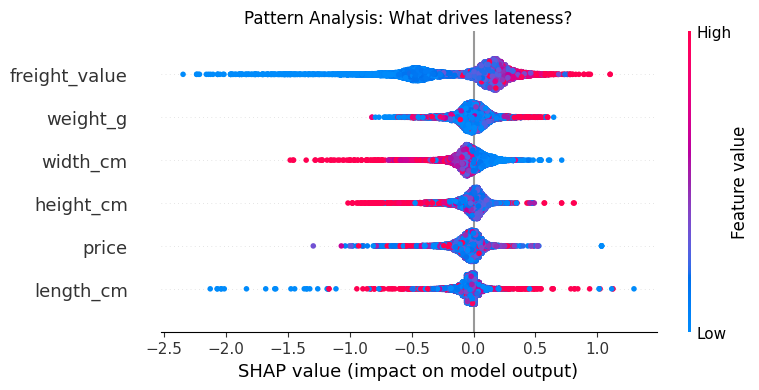

In [6]:
print("\n--- PREDICTIVE PATTERN RECOGNITION ---")

# Prepare Data
features = ['price', 'freight_value', 'weight_g', 'length_cm', 'height_cm', 'width_cm']
X = df[features].fillna(0)
y = df['is_late']

# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Calculate the ratio of On-Time to Late orders
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

model_xgb = XGBClassifier(n_estimators=200, 
                          learning_rate=0.05, 
                          scale_pos_weight=ratio, 
                          max_depth=6)
model_xgb.fit(X_train, y_train)

# Evaluate
print("Model Accuracy Report:")
print(classification_report(y_test, model_xgb.predict(X_test)))

# --- SHAP ANALYSIS (The "Why") ---
# This takes a minute but produces the best insights in data science
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test)

# Plot: Which features matter most?
plt.figure()
plt.title("Pattern Analysis: What drives lateness?")
shap.plots.beeswarm(shap_values, show=True)
# Insights:
# - Red dots on the right = High value of feature causes lateness.
# - Blue dots on the left = Low value of feature prevents lateness.

In [7]:
print("\n--- FORECASTING & WRITE-BACK ---")

# 1. Time Series Forecast
# Resample to monthly order counts
df['ordered_at'] = pd.to_datetime(df['ordered_at'])
monthly_orders = df.set_index('ordered_at').resample('ME').size()

# Simple Forecast: Moving Average of last 3 months
forecast_next_month = monthly_orders.rolling(window=3).mean().iloc[-1]
print(f" PREDICTION: Expect approx. {int(forecast_next_month)} orders next month.")

# 2. Enrich Data with Risk Scores
all_features = df[features].fillna(0)
df['late_risk_score'] = model_xgb.predict_proba(all_features)[:, 1]

# 3. Write to Database
dashboard_table = df[['order_id', 'customer_id', 'ordered_at', 'order_status', 
                      'price', 'freight_value', 'weight_g', 
                      'delay_days', 'late_risk_score']]

table_name = 'predicted_risks'
dashboard_table.to_sql(table_name, engine, schema='analytics', if_exists='replace', index=False)

print(f" SUCCESS: Written {len(dashboard_table)} rows to table 'analytics.{table_name}'")


--- FORECASTING & WRITE-BACK ---
 PREDICTION: Expect approx. 7036 orders next month.
 SUCCESS: Written 110178 rows to table 'analytics.predicted_risks'
